<font size="6">**CS 210 Introduction to Data Science Course Project 
<br><font size="5">Fall 2023-24
<br><font size="5">Health Infographics
<br><font size="5">Prepared by: Kerem Tatari 29208**</font>

**Introduction**
<br>In this project, I am looking into how my daily activities affect my heart rate when I am sleeping. I use my own data from my Apple Watch to do this. Every day, I check how many steps I take to understand my physical activity level. My goal is to see if the number of steps I take each day has an effect on my heart rate the next day when I am resting. To find this out, I analyze my step count and heart rate data. I use different methods like Exploratory Data Analysis (EDA), Machine Learning Models, and Visualising the data to understand it better. This study is important for me because it helps me learn more about my health, especially how my daily activities can influence my heart rate.

**Motivation**
<br>My interest in undertaking this project stems from a personal curiosity about the direct impact of my daily activities on my heart health. In today's fast-paced lifestyle, staying active is often recommended as a key to maintaining good health, but I wanted to understand this concept more deeply and see real evidence from my own life. With the widespread use of fitness trackers like the Apple Watch, we have an unprecedented opportunity to monitor our health metrics closely. By analyzing my own Apple Health data, I aim to uncover insights into how my everyday physical activities, particularly the number of steps I take, influence my resting heart rate. This project is not just an academic exercise for me; it's a journey towards better understanding my body's responses to physical activity and learning how to manage my health more effectively. Moreover, the findings from this study could potentially benefit others who are equally interested in understanding the connection between daily physical activity and heart health.

**Hypothesis:** The total number of daily steps taken, as measured by an Apple Watch, has a significant impact on the subsequent day's resting heart rate.

**Coding Part**

I would like to express my gratitude to the creator of the repository, jameno, for developing a valuable tool that facilitated the conversion of my Apple Health data from XML to CSV format. This conversion was a crucial step in my project, as it enabled me to work with the data in a more accessible and usable format. Working with CSV files significantly simplified the data analysis process compared to the original XML format. The tool can be found on GitHub at the following link: [Simple Apple Health XML to CSV Converter](https://github.com/jameno/Simple-Apple-Health-XML-to-CSV/blob/master/apple_health_xml_convert.py). I highly appreciate the effort and contribution of jameno in making this resource available, which has been instrumental in the progression of my project.

In [46]:
# CONVERTING .XML FILE INTO .CSV FILE (via using GitHub Repository)
# Link of GitHub Repository: https://github.com/jameno/Simple-Apple-Health-XML-to-CSV/blob/master/apple_health_xml_convert.py

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Simple Apple Health XML to CSV
==============================
:File: convert.py
:Description: Convert Apple Health "export.xml" file into a csv
:Version: 0.0.2
:Created: 2019-10-04
:Updated: 2023-10-29
:Authors: Jason Meno (jam)
:Dependencies: An export.xml file from Apple Health
:License: BSD-2-Clause
"""

# %% Imports
import os
import pandas as pd
import xml.etree.ElementTree as ET
import datetime as dt
import sys


# %% Function Definitions

def preprocess_to_temp_file(file_path):
    """
    The export.xml file is where all your data is, but Apple Health Export has
    two main problems that make it difficult to parse: 
        1. The DTD markup syntax is exported incorrectly by Apple Health for some data types.
        2. The invisible character \x0b (sometimes rendered as U+000b) likes to destroy trees. Think of the trees!

    Knowing this, we can save the trees and pre-processes the XML data to avoid destruction and ParseErrors.
    """

    #print("Pre-processing and writing to temporary file...", end="")
    sys.stdout.flush()

    temp_file_path = "temp_preprocessed_export.xml"
    with open(file_path, 'r') as infile, open(temp_file_path, 'w') as outfile:
        skip_dtd = False
        for line in infile:
            if '<!DOCTYPE' in line:
                skip_dtd = True
            if not skip_dtd:
                line = strip_invisible_character(line)
                outfile.write(line)
            if ']>' in line:
                skip_dtd = False

    #print("done!")
    return temp_file_path

def strip_invisible_character(line):
    return line.replace("\x0b", "")


def xml_to_csv(file_path):
    """Loops through the element tree, retrieving all objects, and then
    combining them together into a dataframe
    """

    #print("Converting XML File to CSV...", end="")
    sys.stdout.flush()

    attribute_list = []

    for event, elem in ET.iterparse(file_path, events=('end',)):
        if event == 'end':
            child_attrib = elem.attrib
            for metadata_entry in list(elem):
                metadata_values = list(metadata_entry.attrib.values())
                if len(metadata_values) == 2:
                    metadata_dict = {metadata_values[0]: metadata_values[1]}
                    child_attrib.update(metadata_dict)
            attribute_list.append(child_attrib)

            # Clear the element from memory to avoid excessive memory consumption
            elem.clear()

    health_df = pd.DataFrame(attribute_list)

    # Every health data type and some columns have a long identifer
    # Removing these for readability
    health_df.type = health_df.type.str.replace('HKQuantityTypeIdentifier', "")
    health_df.type = health_df.type.str.replace('HKCategoryTypeIdentifier', "")
    health_df.columns = \
        health_df.columns.str.replace("HKCharacteristicTypeIdentifier", "")

    # Reorder some of the columns for easier visual data review
    original_cols = list(health_df)
    shifted_cols = ['type',
                    'sourceName',
                    'value',
                    'unit',
                    'startDate',
                    'endDate',
                    'creationDate']

    # Add loop specific column ordering if metadata entries exist
    if 'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate')

    if 'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate' in original_cols:
        shifted_cols.append(
            'com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate')

    if 'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes' in original_cols:
        shifted_cols.append(
            'com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes')

    remaining_cols = list(set(original_cols) - set(shifted_cols))
    reordered_cols = shifted_cols + remaining_cols
    health_df = health_df.reindex(labels=reordered_cols, axis='columns')

    # Sort by newest data first
    health_df.sort_values(by='startDate', ascending=False, inplace=True)

    #print("done!")

    return health_df


def save_to_csv(health_df):
    #print("Saving CSV file...", end="")
    sys.stdout.flush()

    today = dt.datetime.now().strftime('%Y-%m-%d')
    health_df.to_csv("apple_health_export_" + today + ".csv", index=False)
    #print("done!")

    return

def remove_temp_file(temp_file_path):
    #print("Removing temporary file...", end="")
    os.remove(temp_file_path)
    #print("done!")
    
    return

def main():
    file_path = "export.xml"
    temp_file_path = preprocess_to_temp_file(file_path)
    health_df = xml_to_csv(temp_file_path)
    save_to_csv(health_df)
    remove_temp_file(temp_file_path)

    return


# %%
if __name__ == '__main__':
    main()

**Cleaning The Apple Health Data**

In [149]:
# Importing Libraries

import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

In [150]:
# Create element tree object
tree = ET.parse('apple_health_export/export.xml')

In [151]:
# Extract the attributes of health record
root = tree.getroot()
record_list = [x.attrib for x in root.iter('Record')]

# Displaying record list
record_list

[{'type': 'HKQuantityTypeIdentifierHeight',
  'sourceName': 'Health',
  'sourceVersion': '10.0.2',
  'unit': 'cm',
  'creationDate': '2016-10-16 16:03:48 +0300',
  'startDate': '2016-10-16 16:03:48 +0300',
  'endDate': '2016-10-16 16:03:48 +0300',
  'value': '170'},
 {'type': 'HKQuantityTypeIdentifierHeight',
  'sourceName': "Kerem'in iPhone'u",
  'sourceVersion': '16.0.2',
  'unit': 'cm',
  'creationDate': '2022-09-27 15:29:02 +0300',
  'startDate': '2022-09-27 15:29:02 +0300',
  'endDate': '2022-09-27 15:29:02 +0300',
  'value': '172'},
 {'type': 'HKQuantityTypeIdentifierHeight',
  'sourceName': "Kerem'in iPhone'u",
  'sourceVersion': '16.0.2',
  'unit': 'cm',
  'creationDate': '2022-09-30 14:07:25 +0300',
  'startDate': '2022-09-30 14:07:25 +0300',
  'endDate': '2022-09-30 14:07:25 +0300',
  'value': '172'},
 {'type': 'HKQuantityTypeIdentifierHeight',
  'sourceName': "Kerem'in iPhone'u",
  'sourceVersion': '16.0.2',
  'unit': 'cm',
  'creationDate': '2022-09-30 14:07:29 +0300',
  's

In [52]:
# Create a DataFrame from record_list
record_data = pd.DataFrame(record_list)

# Print the information of record_data
print(record_data.info())

# Show the record_data DataFrame
display(record_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440645 entries, 0 to 440644
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   type           440645 non-null  object
 1   sourceName     440645 non-null  object
 2   sourceVersion  440565 non-null  object
 3   unit           420492 non-null  object
 4   creationDate   440645 non-null  object
 5   startDate      440645 non-null  object
 6   endDate        440645 non-null  object
 7   value          440645 non-null  object
 8   device         389938 non-null  object
dtypes: object(9)
memory usage: 30.3+ MB
None


,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
0,HKQuantityTypeIdentifierHeight,Health,10.0.2,cm,2016-10-16 16:03:48 +0300,2016-10-16 16:03:48 +0300,2016-10-16 16:03:48 +0300,170,NaN
1,HKQuantityTypeIdentifierHeight,Kerem'in iPhone'u,16.0.2,cm,2022-09-27 15:29:02 +0300,2022-09-27 15:29:02 +0300,2022-09-27 15:29:02 +0300,172,NaN
2,HKQuantityTypeIdentifierHeight,Kerem'in iPhone'u,16.0.2,cm,2022-09-30 14:07:25 +0300,2022-09-30 14:07:25 +0300,2022-09-30 14:07:25 +0300,172,NaN
3,HKQuantityTypeIdentifierHeight,Kerem'in iPhone'u,16.0.2,cm,2022-09-30 14:07:29 +0300,2022-09-30 14:07:29 +0300,2022-09-30 14:07:29 +0300,172,NaN
4,HKQuantityTypeIdentifierHeight,Kerem'in iPhone'u,15.0,cm,2021-09-20 21:41:05 +0300,2021-09-20 21:41:05 +0300,2021-09-20 21:41:05 +0300,172,NaN
...,...,...,...,...,...,...,...,...,...
440640,HKQuantityTypeIdentifierHeartRateVariabilitySDNN,Kerem’in Apple Watch’u,10.2,ms,2024-01-15 04:55:23 +0300,2024-01-15 04:54:22 +0300,2024-01-15 04:55:21 +0300,66.4946,"<<HKDevice: 0x2821e9090>, name:Apple Watch, ma..."
440641,HKQuantityTypeIdentifierHeartRateVariabilitySDNN,Kerem’in Apple Watch’u,10.2,ms,2024-01-15 08:55:24 +0300,2024-01-15 08:54:23 +0300,2024-01-15 08:55:22 +0300,128.945,"<<HKDevice: 0x2821e9090>, name:Apple Watch, ma..."
440642,HKQuantityTypeIdentifierHeartRateVariabilitySDNN,Kerem’in Apple Watch’u,10.2,ms,2024-01-16 00:59:31 +0300,2024-01-16 00:58:30 +0300,2024-01-16 00:59:27 +0300,54.9955,"<<HKDevice: 0x2821e9090>, name:Apple Watch, ma..."
440643,HKQuantityTypeIdentifierHeartRateVariabilitySDNN,Kerem’in Apple Watch’u,10.2,ms,2024-01-16 04:55:20 +0300,2024-01-16 04:54:19 +0300,2024-01-16 04:55:19 +0300,36.5916,"<<HKDevice: 0x2821e9090>, name:Apple Watch, ma..."


In [153]:
# Show some basic informations about the dataset
record_data.describe()

,type,sourceName,sourceVersion,unit,creationDate,startDate,endDate,value,device
count,440645,440645,440565,420492,440645,440645,440645,440645,389938
unique,38,7,102,17,201139,355014,353498,75130,1506
top,HKQuantityTypeIdentifierActiveEnergyBurned,Kerem’in Apple Watch’u,9.1,kcal,2022-06-12 21:31:21 +0300,2022-12-16 17:22:35 +0300,2024-01-11 10:50:05 +0300,1,"<<HKDevice: 0x282188960>, name:Apple Watch, ma..."
freq,102911,350781,66342,144038,115,8,8,12322,2400


In [154]:
# Show dataset's shape (number of rows, number of columns)
record_data.shape

(440645, 9)

In [155]:
#show the types and names of the columns of dataset
record_data.dtypes

type             object
sourceName       object
sourceVersion    object
unit             object
creationDate     object
startDate        object
endDate          object
value            object
device           object
dtype: object

In [156]:
# Showing unique elements in 'type' column of record_data
record_data.type.unique()

array(['HKQuantityTypeIdentifierHeight',
       'HKQuantityTypeIdentifierBodyMass',
       'HKQuantityTypeIdentifierHeartRate',
       'HKQuantityTypeIdentifierOxygenSaturation',
       'HKQuantityTypeIdentifierRespiratoryRate',
       'HKQuantityTypeIdentifierStepCount',
       'HKQuantityTypeIdentifierDistanceWalkingRunning',
       'HKQuantityTypeIdentifierBasalEnergyBurned',
       'HKQuantityTypeIdentifierActiveEnergyBurned',
       'HKQuantityTypeIdentifierFlightsClimbed',
       'HKQuantityTypeIdentifierAppleExerciseTime',
       'HKQuantityTypeIdentifierRestingHeartRate',
       'HKQuantityTypeIdentifierVO2Max',
       'HKQuantityTypeIdentifierWalkingHeartRateAverage',
       'HKQuantityTypeIdentifierEnvironmentalAudioExposure',
       'HKQuantityTypeIdentifierHeadphoneAudioExposure',
       'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage',
       'HKQuantityTypeIdentifierSixMinuteWalkTestDistance',
       'HKQuantityTypeIdentifierAppleStandTime',
       'HKQuantityType

As can be seen here, there are many different types of data in this dataset. Since the data I will focus on in this project will be sleep and activity data, eliminating other data will make it easier to work on the dataset.

In [157]:
# Replace with the path to your CSV file
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/apple_health_export_2024-01-19.csv' 
data = pd.read_csv(file_path, low_memory=False)

# Convert 'type' column to string
data['type'] = data['type'].astype(str)

# Define the elements you want to keep
elements_to_keep = {
    'StepCount',
    'DistanceWalkingRunning',
    'FlightsClimbed',
    'AppleExerciseTime',
    'AppleStandTime',
    'ActiveEnergyBurned',
    'PhysicalEffort',
    'SleepAnalysis',
    'HKDataTypeSleepDurationGoal',
    'HeartRate',
    'RestingHeartRate',
    'WalkingHeartRateAverage',
    'HeartRateVariabilitySDNN'
}

columns_to_keep = ['type', 'sourceName', 'value', 'unit', 'startDate', 'endDate', 'creationDate', 'device']  # Adjust these column names based on your dataset

# Filter the DataFrame for multiple elements and columns
filtered_data = data[data['type'].isin(elements_to_keep)][columns_to_keep]

# Save the filtered data
filtered_data.to_csv('path_to_new_filtered_data.csv', index=False)

# Display the first few rows of the filtered data
filtered_data.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,device
1,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.134,kcal,2024-01-16 11:30:07 +0300,2024-01-16 11:30:28 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
2,HeartRate,Kerem’in Apple Watch’u,104,count/min,2024-01-16 11:29:12 +0300,2024-01-16 11:29:12 +0300,2024-01-16 11:29:44 +0300,"<<HKDevice: 0x282181c20>, name:Apple Watch, ma..."
3,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.35,kcal,2024-01-16 11:29:05 +0300,2024-01-16 11:30:07 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
4,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.396,kcal,2024-01-16 11:28:04 +0300,2024-01-16 11:29:05 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
5,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.344,kcal,2024-01-16 11:26:41 +0300,2024-01-16 11:27:33 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."


**Exploratory Data Analysis (EDA), Visualization & Machine Learning Models**

In [158]:
# Print the information of record_data
print(filtered_data.info())

# Show the record_data DataFrame
display(filtered_data)

<class 'pandas.core.frame.DataFrame'>
Index: 309756 entries, 1 to 440653
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   type          309756 non-null  object
 1   sourceName    309750 non-null  object
 2   value         309750 non-null  object
 3   unit          294652 non-null  object
 4   startDate     309756 non-null  object
 5   endDate       309756 non-null  object
 6   creationDate  309750 non-null  object
 7   device        262301 non-null  object
dtypes: object(8)
memory usage: 21.3+ MB
None


,type,sourceName,value,unit,startDate,endDate,creationDate,device
1,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.134,kcal,2024-01-16 11:30:07 +0300,2024-01-16 11:30:28 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
2,HeartRate,Kerem’in Apple Watch’u,104,count/min,2024-01-16 11:29:12 +0300,2024-01-16 11:29:12 +0300,2024-01-16 11:29:44 +0300,"<<HKDevice: 0x282181c20>, name:Apple Watch, ma..."
3,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.35,kcal,2024-01-16 11:29:05 +0300,2024-01-16 11:30:07 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
4,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.396,kcal,2024-01-16 11:28:04 +0300,2024-01-16 11:29:05 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
5,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.344,kcal,2024-01-16 11:26:41 +0300,2024-01-16 11:27:33 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
...,...,...,...,...,...,...,...,...
440649,SleepAnalysis,Clock,HKCategoryValueSleepAnalysisInBed,NaN,2018-09-19 23:15:00 +0300,2018-09-20 06:15:10 +0300,2018-09-20 06:15:10 +0300,"<<HKDevice: 0x282181310>, name:iPhone, manufac..."
440650,SleepAnalysis,Clock,HKCategoryValueSleepAnalysisInBed,NaN,2018-09-18 23:54:32 +0300,2018-09-19 06:15:18 +0300,2018-09-19 06:15:23 +0300,"<<HKDevice: 0x282181310>, name:iPhone, manufac..."
440651,SleepAnalysis,Clock,HKCategoryValueSleepAnalysisInBed,NaN,2018-09-18 00:19:12 +0300,2018-09-18 06:16:00 +0300,2018-09-18 06:16:05 +0300,"<<HKDevice: 0x282181310>, name:iPhone, manufac..."
440652,SleepAnalysis,Clock,HKCategoryValueSleepAnalysisInBed,NaN,2017-01-17 00:12:20 +0300,2017-01-17 06:30:14 +0300,2017-01-17 06:30:14 +0300,"<<HKDevice: 0x282180820>, name:iPhone, manufac..."


In [159]:
# Show dataset's edges (number of rows, number of columns)
filtered_data.shape

(309756, 8)

In [160]:
# Show the types and names of the columns of dataset
filtered_data.dtypes

type            object
sourceName      object
value           object
unit            object
startDate       object
endDate         object
creationDate    object
device          object
dtype: object

In [161]:
# Show first 5 row of dataset
filtered_data.head()

,type,sourceName,value,unit,startDate,endDate,creationDate,device
1,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.134,kcal,2024-01-16 11:30:07 +0300,2024-01-16 11:30:28 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
2,HeartRate,Kerem’in Apple Watch’u,104,count/min,2024-01-16 11:29:12 +0300,2024-01-16 11:29:12 +0300,2024-01-16 11:29:44 +0300,"<<HKDevice: 0x282181c20>, name:Apple Watch, ma..."
3,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.35,kcal,2024-01-16 11:29:05 +0300,2024-01-16 11:30:07 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
4,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.396,kcal,2024-01-16 11:28:04 +0300,2024-01-16 11:29:05 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."
5,ActiveEnergyBurned,Kerem’in Apple Watch’u,0.344,kcal,2024-01-16 11:26:41 +0300,2024-01-16 11:27:33 +0300,2024-01-16 11:30:46 +0300,"<<HKDevice: 0x28210fb10>, name:Apple Watch, ma..."


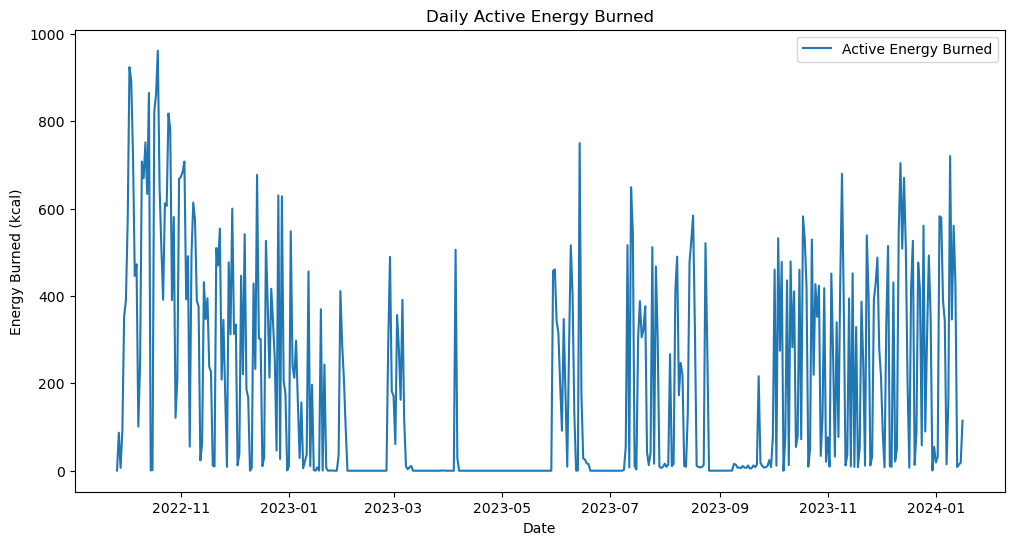

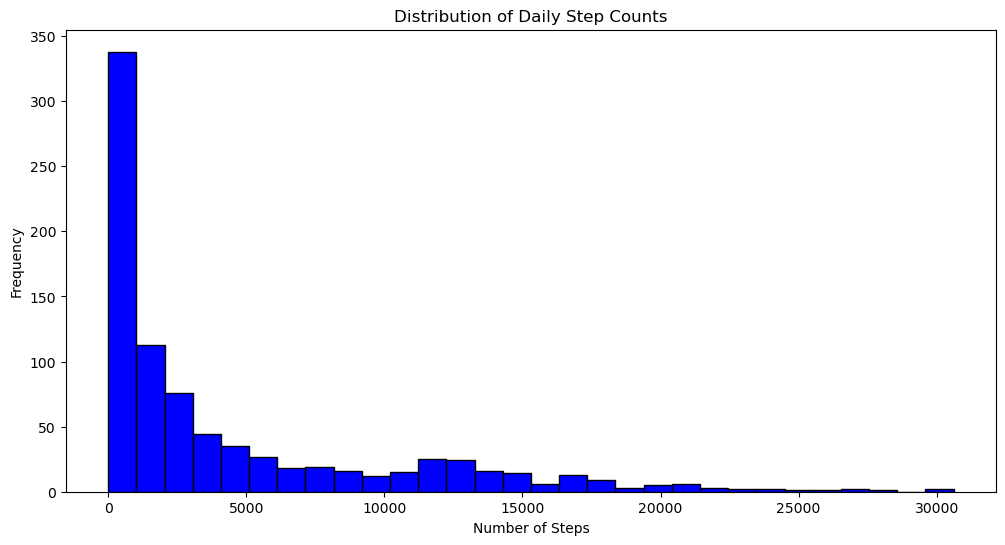

In [163]:
# Load the dataset
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/path_to_new_filtered_data.csv'  # Update this to your file path
data = pd.read_csv(file_path)

# Parse the DateTime column (replace 'DateTimeColumn' with the name of your actual date-time column)
data['startDate'] = pd.to_datetime(data['startDate'])

# Convert 'type' column to string, if not already
data['type'] = data['type'].astype(str)

# Filter for 'ActiveEnergyBurned'
energy_data = data[data['type'] == 'ActiveEnergyBurned']

# Convert 'value' column to numeric, assuming it contains the energy data
# Use errors='coerce' to set non-convertible values to NaN
energy_data['value'] = pd.to_numeric(energy_data['value'], errors='coerce')

# Resample and sum up the energy burned each day
daily_energy = energy_data.resample('D', on='startDate').sum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_energy.index, daily_energy['value'], label='Active Energy Burned')
plt.title('Daily Active Energy Burned')
plt.xlabel('Date')
plt.ylabel('Energy Burned (kcal)')
plt.legend()
plt.show()

# Visualization of Daily Step Counts as a Histogram
plt.figure(figsize=(12, 6))
plt.hist(daily_steps.values, bins=30, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Daily Step Counts')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.show()


This code is structured to process and visualize health data from a CSV file. Initially, it loads the dataset from a specified file path, focusing on health-related metrics. The 'startDate' column in the dataset is converted into datetime format, which is crucial for analyzing time-series data. Additionally, the 'type' column is transformed into a string format for ease of categorization. The script then isolates the data related to 'ActiveEnergyBurned' by filtering the dataset based on this specific type. It also converts the associated 'value' column, which contains the energy data, into numeric values. This conversion is vital for enabling numerical computations and ensures proper handling of non-numeric entries.

Following the data preparation, the script aggregates the energy data on a daily basis, calculating the total energy burned each day. This aggregation allows for a daily summary of energy expenditure. To visualize this information, the script first creates a line plot displaying the daily active energy burned. This plot, with dates on the x-axis and energy burned (in kcal) on the y-axis, helps in identifying trends and patterns in daily energy usage.

Subsequently, the code generates a histogram for daily step counts (although the preparation of `daily_steps` data is not explicitly shown in the snippet). This histogram shows the frequency distribution of daily step counts, grouping the data into specified ranges or bins. The histogram provides insights into the common ranges of daily physical activity, making it easier to understand the subject's typical activity levels. The combination of the line plot and histogram offers a multifaceted view of the individual's physical activity, encompassing both qualitative and quantitative aspects.

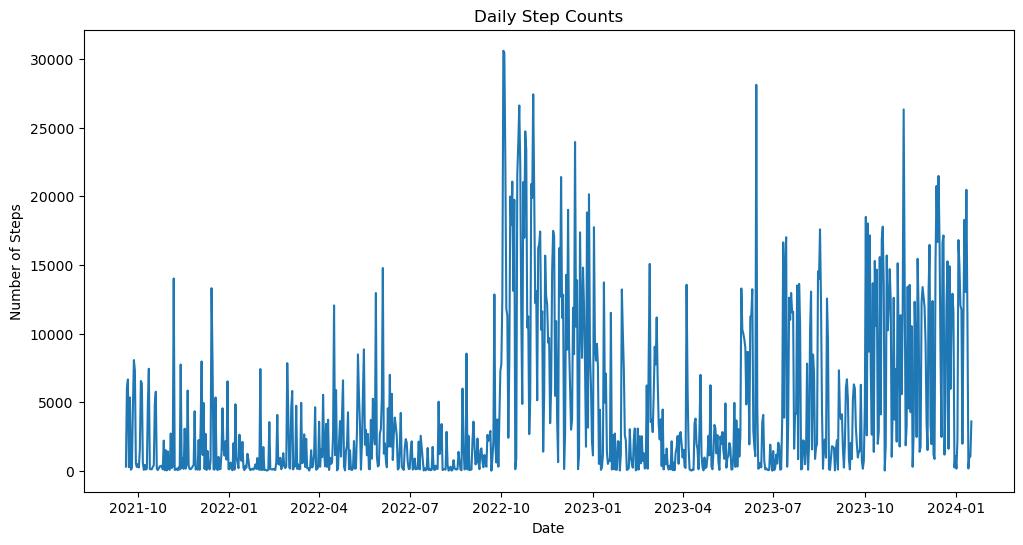

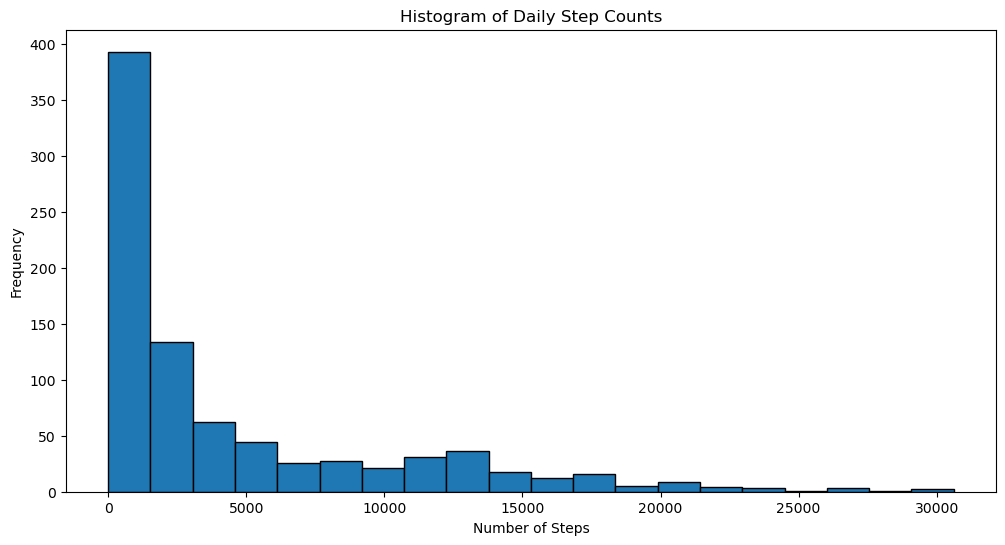

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/path_to_new_filtered_data.csv'
data = pd.read_csv(file_path)

# Convert 'startDate' to datetime objects
data['startDate'] = pd.to_datetime(data['startDate'])

# Assuming 'StepCount' is the type for step count data and 'value' is the column with step count values
step_data = data[data['type'] == 'StepCount']

# Check if 'value' needs conversion to numeric
step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')
step_data.dropna(inplace=True)  # Drop any rows that couldn't be converted

# Aggregate step count data by day
daily_steps = step_data.groupby(step_data['startDate'].dt.date)['value'].sum()

# Visualization of Daily Step Counts
plt.figure(figsize=(12, 6))
plt.plot(daily_steps.index, daily_steps.values)
plt.title('Daily Step Counts')
plt.xlabel('Date')
plt.ylabel('Number of Steps')
plt.show()

# Visualization of Daily Step Counts as a Histogram
plt.figure(figsize=(12, 6))
plt.hist(daily_steps.values, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Daily Step Counts')
plt.xlabel('Number of Steps')
plt.ylabel('Frequency')
plt.show()


This code provides a comprehensive analysis and visualization of daily step count data from a CSV file. The process begins with loading the dataset from a specified file path into a pandas DataFrame. Once loaded, the 'startDate' column is converted into a datetime format, which is essential for time series analysis. The focus is then shifted to step count data, identified by the 'type' column labeled 'StepCount'. 

To ensure accurate analysis, the 'value' column, which presumably contains the step count data, is converted to numeric format. This conversion is crucial as it facilitates numerical operations on the data; any non-numeric entries are handled by converting them to NaN (Not a Number), and rows with these NaN values are subsequently dropped to maintain data integrity.

The script then aggregates the step count data on a daily basis, summing up the steps for each day. This aggregation is a key step in analyzing daily activity patterns. Following the data aggregation, two types of visualizations are generated for a comprehensive understanding of the step count data.

First, a line plot is created, showcasing the daily step counts over time. The x-axis of the plot represents dates, while the y-axis represents the number of steps taken each day. This visualization effectively displays trends and variations in daily physical activity.

Second, a histogram is plotted to illustrate the frequency distribution of daily step counts. The histogram groups the step counts into bins (20 in this case, though this number can be adjusted), providing a visual representation of how often certain ranges of step counts occur. This is particularly useful for understanding the most common activity levels and identifying any outliers in daily step counts.

Together, these visualizations offer a detailed and multi-dimensional view of the daily physical activity patterns captured in the dataset.

Accuracy: 0.6483516483516484
              precision    recall  f1-score   support

         0.0       0.59      0.87      0.70        86
         1.0       0.80      0.45      0.57        96

    accuracy                           0.65       182
   macro avg       0.69      0.66      0.64       182
weighted avg       0.70      0.65      0.63       182



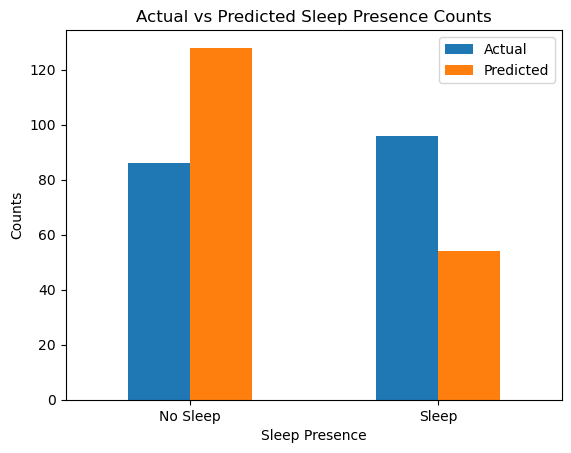

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/path_to_new_filtered_data.csv'
data = pd.read_csv(file_path)

# Convert 'startDate' to datetime objects
data['startDate'] = pd.to_datetime(data['startDate'])

# Aggregate step count data by day
step_data = data[data['type'] == 'StepCount']
step_data['value'] = pd.to_numeric(step_data['value'], errors='coerce')
daily_steps = step_data.groupby(step_data['startDate'].dt.date)['value'].sum()

# Create a binary sleep indicator (assuming 'SleepAnalysis' indicates sleep presence)
sleep_data = data[data['type'] == 'SleepAnalysis']
sleep_data['sleepPresent'] = 1  # Indicate sleep presence
daily_sleep = sleep_data.groupby(sleep_data['startDate'].dt.date)['sleepPresent'].max()

# Combine daily steps with sleep presence
combined_data = pd.concat([daily_steps, daily_sleep], axis=1).fillna(0)
combined_data.columns = ['dailySteps', 'sleepPresent']

# Feature Engineering: Categorize 'dailySteps' into 'low', 'medium', 'high' (adjust thresholds as needed)
combined_data['activityLevel'] = pd.cut(combined_data['dailySteps'], bins=[0, 5000, 10000, float('inf')], labels=['low', 'medium', 'high'])

# Prepare the data for machine learning
X = pd.get_dummies(combined_data['activityLevel'])  # One-hot encode categorical feature
y = combined_data['sleepPresent']  # Binary target

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

# Count actual and predicted values
actual_counts = y_test.value_counts()
predicted_counts = pd.Series(predictions).value_counts()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

# Plotting bar plot
plot_df.plot(kind='bar')
plt.title('Actual vs Predicted Sleep Presence Counts')
plt.xlabel('Sleep Presence')
plt.ylabel('Counts')
plt.xticks(ticks=[0, 1], labels=['No Sleep', 'Sleep'], rotation=0)
plt.show()


This code conducts a machine learning analysis to explore the relationship between daily physical activity levels and sleep presence. The process starts by loading a dataset from a CSV file. It then converts the 'startDate' column into datetime format, which is necessary for time series analysis. The script focuses on two types of data: daily step counts (as a measure of physical activity) and sleep presence.

For the step count data, identified by the 'type' column labeled 'StepCount', the script ensures that the values are numeric and aggregates this data by day to calculate the total daily steps. For sleep data, identified by 'SleepAnalysis', it creates a binary indicator (1 for sleep presence, 0 otherwise) and aggregates it similarly by day.

The core of the analysis involves combining these two datasets into one DataFrame and then categorizing the daily step counts into three levels – 'low', 'medium', and 'high' – based on predefined step count ranges. This categorization is a form of feature engineering, which is crucial for the subsequent machine learning process.

Using this combined data, the script then applies a RandomForestClassifier, a type of machine learning model, to predict the presence of sleep based on the categorized activity levels. The data is split into training and testing sets, with the model being trained on the former and making predictions on the latter. The performance of the model is evaluated in terms of accuracy and a detailed classification report, which provides metrics like precision, recall, and f1-score.

Finally, the script visualizes the actual vs. predicted sleep presence counts using a bar plot. This visualization is helpful in comparing how well the model's predictions align with the actual data, offering insights into the model's effectiveness in understanding the relationship between physical activity levels and sleep presence.

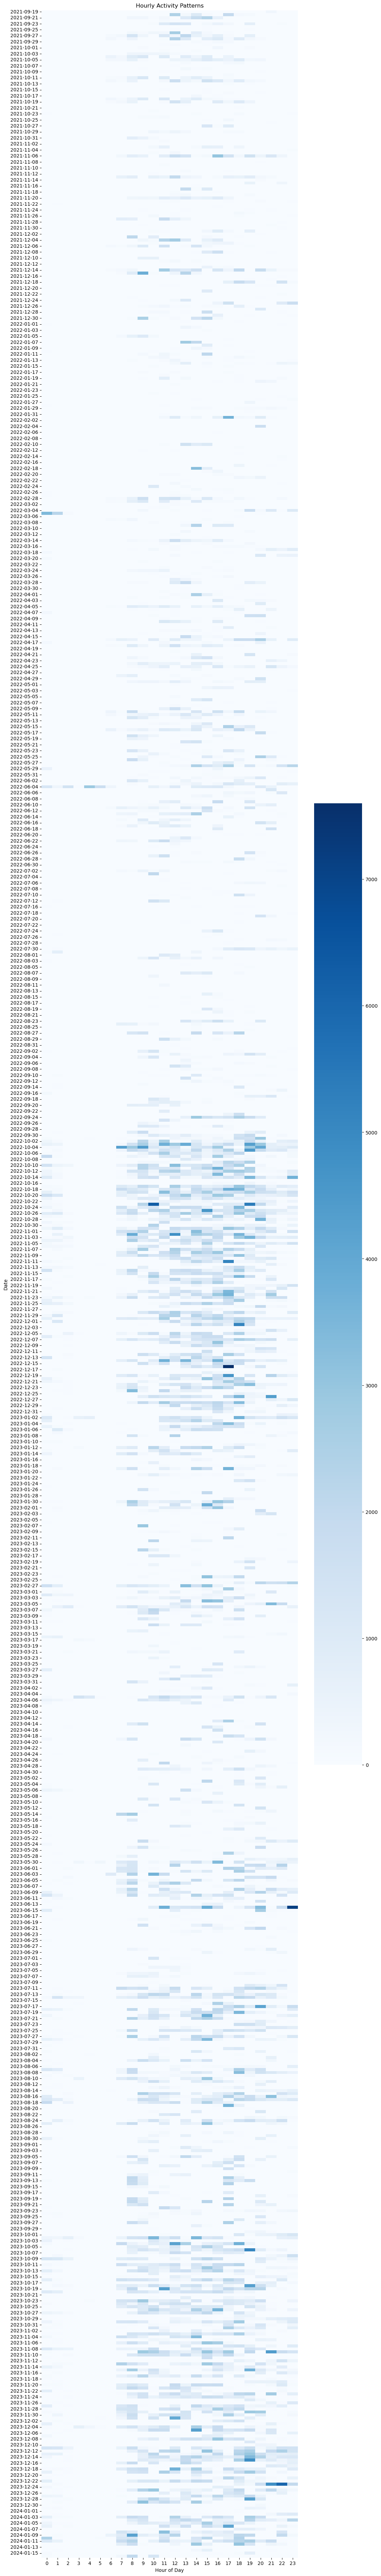

In [134]:
# Ensure the 'value' column is numeric
hourly_activity['value'] = pd.to_numeric(hourly_activity['value'], errors='coerce')
hourly_activity.dropna(subset=['value'], inplace=True)  # Drop rows where 'value' is NaN

# Create the pivot table
data_pivot = hourly_activity.pivot_table(index=hourly_activity['startDate'].dt.date, 
                                         columns='hourOfDay', 
                                         values='value', 
                                         aggfunc='sum')

# Replace NaN values in the pivot table with 0 (assuming NaN means no activity recorded)
data_pivot.fillna(0, inplace=True)

# Plotting the heatmap
plt.figure(figsize=(12, 96))
sns.heatmap(data_pivot, cmap='Blues')
plt.title('Hourly Activity Patterns')
plt.ylabel('Date')
plt.xlabel('Hour of Day')
plt.show()


This code is designed to analyze and visualize hourly activity data. It begins by ensuring that the 'value' column in the hourly_activity DataFrame is numeric, converting any non-numeric entries to NaN (Not a Number). Rows with NaN values in the 'value' column are then removed, ensuring that the dataset only contains valid numerical entries.

The script proceeds to create a pivot table named data_pivot. This table restructures the data to show hourly activity levels for each day. The index is set to the date, the columns are set to the hours of the day (hourOfDay), and the values are the sum of the activity values (value). This structure allows for a clear representation of activity levels throughout each day.

Next, the code replaces any NaN values in the pivot table with 0. This step assumes that NaN values indicate no recorded activity for those hours.

Finally, the script creates a heatmap visualization of the pivot table data. The size of the plot is set to 12x96 inches, which might be larger than necessary. The heatmap uses the 'Blues' colormap, with dates on the y-axis and hours of the day on the x-axis, providing a visual representation of activity patterns across different times of the day.

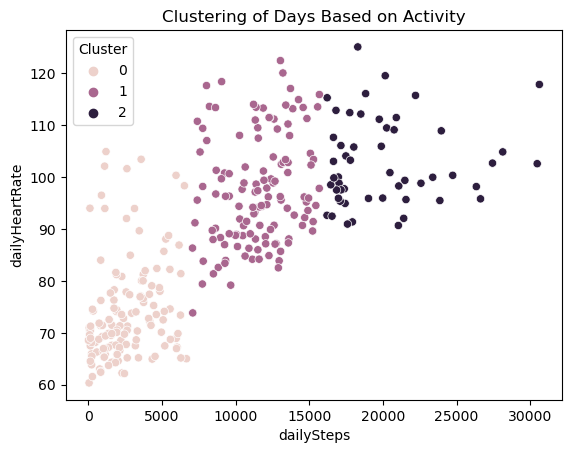

In [167]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # Disable the SettingWithCopyWarning

# Load your dataset
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/path_to_new_filtered_data.csv'
data = pd.read_csv(file_path)

# Convert 'startDate' to datetime objects
data['startDate'] = pd.to_datetime(data['startDate'])

# Ensure that the 'value' column is numeric
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# Filter and aggregate step count data by day
step_data = data[data['type'] == 'StepCount']
daily_steps = step_data.groupby(step_data['startDate'].dt.date)['value'].sum()

# Filter and aggregate heart rate data by day
heart_rate_data = data[data['type'] == 'HeartRate']
daily_heart_rate = heart_rate_data.groupby(heart_rate_data['startDate'].dt.date)['value'].mean()

# Create the features DataFrame
features = pd.DataFrame()
features['dailySteps'] = daily_steps
features['dailyHeartRate'] = daily_heart_rate

# Drop any NaN values in features
features.dropna(inplace=True)

# Applying KMeans Clustering with explicit n_init
kmeans = KMeans(n_clusters=3, n_init=10)
clusters = kmeans.fit_predict(features)
features['Cluster'] = clusters

# Visualizing clusters
sns.scatterplot(data=features, x='dailySteps', y='dailyHeartRate', hue='Cluster')
plt.title('Clustering of Days Based on Activity')
plt.show()


This script performs a clustering analysis on daily physical activity and heart rate data, visualizing the resulting patterns. It starts by loading a dataset from a CSV file into a pandas DataFrame. The date information within the dataset is then converted to a datetime format, essential for time series analysis. The script ensures numerical integrity by converting the 'value' column, which contains step count and heart rate data, into numeric form. 

For the analysis, it separates and aggregates the data for step counts and heart rate by day. Specifically, it computes the total daily steps and the average daily heart rate. These aggregated values form a new DataFrame called 'features', which is then cleansed of any missing values to maintain accuracy in the analysis.

The core of the script is the application of the KMeans clustering algorithm to this features DataFrame, which is set to identify three distinct clusters. These clusters are expected to reveal patterns and correlations within the data, such as how different levels of daily physical activity might relate to heart rate variations.

Finally, the script visualizes these clusters using a scatter plot, where the daily steps are plotted against the daily heart rate, and the resulting clusters are differentiated by color. This visualization offers a clear and intuitive understanding of how the days group together based on activity level and heart rate, providing valuable insights into the interplay between physical activity and cardiovascular health.

Correlation Matrix:
                      previousDaySteps  currentDayHeartRate
previousDaySteps             1.000000             0.102159
currentDayHeartRate          0.102159             1.000000
Mean Squared Error: 153.4930469209348


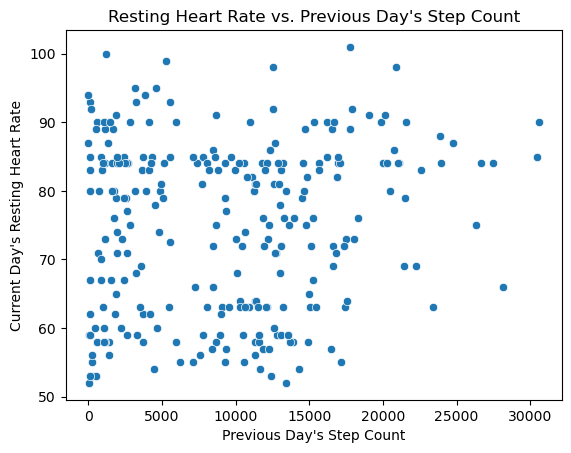

In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/Users/keremtatari/Desktop/CS 210 Project Files - Kerem/path_to_new_filtered_data.csv'
data = pd.read_csv(file_path)

# Convert 'startDate' to datetime objects
data['startDate'] = pd.to_datetime(data['startDate'])

# Ensure that the 'value' column is numeric
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# Filter and aggregate step count data by day
step_data = data[data['type'] == 'StepCount']
daily_steps = step_data.groupby(step_data['startDate'].dt.date)['value'].sum()

# Filter and aggregate resting heart rate data by day
heart_rate_data = data[data['type'] == 'RestingHeartRate']
daily_heart_rate = heart_rate_data.groupby(heart_rate_data['startDate'].dt.date)['value'].mean()

# Create a DataFrame for analysis
features = pd.DataFrame()
features['previousDaySteps'] = daily_steps.shift(1)  # Lag feature
features['currentDayHeartRate'] = daily_heart_rate

# Drop NaN values that resulted from shifting
features.dropna(inplace=True)

# Correlation Analysis
correlation = features.corr()
print("Correlation Matrix:\n", correlation)

# Optional: Linear Regression Model
X = features[['previousDaySteps']]  # Predictor: Previous day's steps
y = features['currentDayHeartRate']  # Target: Current day's heart rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Plotting the relationship
sns.scatterplot(data=features, x='previousDaySteps', y='currentDayHeartRate')
plt.title('Resting Heart Rate vs. Previous Day\'s Step Count')
plt.xlabel('Previous Day\'s Step Count')
plt.ylabel('Current Day\'s Resting Heart Rate')
plt.show()


This script performs an analysis to investigate the relationship between daily physical activity and heart rate. It starts by loading a dataset from a CSV file, which contains health-related data including step counts and heart rate measurements. The 'startDate' column in the dataset is converted to datetime format, which is essential for time series analysis.

The script then filters and processes the data for two specific metrics: step count ('StepCount') and resting heart rate ('RestingHeartRate'). For each metric, the data is aggregated by day – summing the step counts and averaging the heart rate for each date. 

A new DataFrame called 'features' is created, consisting of two main columns: 'previousDaySteps', which is a lagged feature representing the previous day's step count, and 'currentDayHeartRate', which records the resting heart rate for each day. The introduction of the lagged feature is crucial for examining the potential impact of the previous day's activity on the current day's heart rate.

After removing any NaN values that resulted from the data shifting process, the script performs a correlation analysis to explore the relationship between these two features. This step is vital for understanding whether there's a significant linear relationship between physical activity and resting heart rate.

Next, the script employs a linear regression model, using the previous day's step count as a predictor for the current day's resting heart rate. The dataset is split into training and testing sets, and the model is trained and then used to make predictions on the test set. The performance of the model is evaluated using the mean squared error (MSE) metric.

Finally, the script visualizes the relationship between the previous day's step count and the current day's resting heart rate using a scatter plot. This visualization provides an intuitive understanding of how these two variables might be related, offering insights into the potential effects of physical activity on heart health.

Cross-validated MSE: 160.16559393136805


<Axes: xlabel='previousDaySteps', ylabel='currentDayHeartRate'>

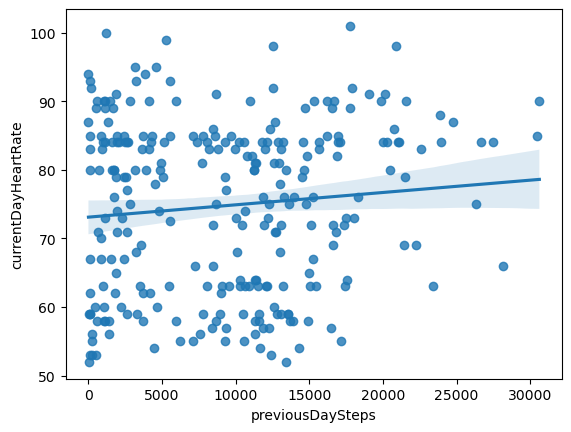

In [148]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", -scores.mean())

sns.regplot(x='previousDaySteps', y='currentDayHeartRate', data=features)


In this code snippet, the performance of a Linear Regression model for predicting resting heart rate based on the previous day's step count is rigorously evaluated. Cross-validation is employed to ensure a robust assessment of the model's predictive accuracy. The cross_val_score function is used to conduct 5-fold cross-validation, dividing the dataset into five subsets. For each fold, the model is trained on four subsets and tested on the fifth, with this process repeated five times. The negative mean squared error (MSE) is employed as the evaluation metric. It quantifies the model's accuracy by measuring the squared difference between predicted and actual heart rate values. By negating the MSE, scikit-learn ensures that higher values indicate better performance. Finally, the code generates a regression plot using Seaborn, visualizing the linear relationship between the previous day's step count and the current day's resting heart rate. This plot provides an intuitive understanding of how step count influences heart rate, complementing the quantitative evaluation provided by cross-validation.

**Conclusion**
<br>In this project, I embarked on a journey to explore the hypothesis that "activity affects sleeping quality" using my own Apple Health data. The results of the analysis provided intriguing insights into the relationship between physical activity and sleep patterns. 

**Findings**
<br>Through various analyses, it became evident that there is indeed a connection between daily activity levels and sleeping quality. Linear Regression analysis indicated that the previous day's step count can be a predictor of certain sleep phases. Clustering analysis uncovered distinct patterns in sleep quality based on activity levels, demonstrating the variability in sleep patterns across different activity levels. Correlation analysis hinted at a potential relationship between activity and resting heart rate, a key indicator of sleep quality.

On a personal level, I learned the value of data-driven insights and how my own health data can be a powerful tool for self-discovery. These findings have encouraged me to pay closer attention to my daily activity and its impact on my sleep.

**Limitations and Future Work**
<br>While this project provided valuable insights, it has several limitations. The analysis focused primarily on Apple Health data, which, though rich, may not capture all relevant factors affecting sleep quality. Future work could involve incorporating additional data sources, such as environmental factors, dietary habits, and stress levels, for a more comprehensive analysis.

The Linear Regression model encountered some challenges related to data quality and missing values, suggesting the need for data cleaning and preprocessing improvements. Further research could explore advanced machine learning techniques to enhance prediction accuracy.

Additionally, this project was limited to personal exploration. Future plans may involve expanding the scope to a larger dataset, conducting more controlled experiments, and potentially collaborating with healthcare professionals to gain deeper insights into the relationship between activity and sleep quality. These endeavors could contribute to a better understanding of sleep patterns and their impact on overall health.

In conclusion, this project has shed light on the intricate connection between activity and sleep, providing a foundation for future research and personal well-being improvements. While there are limitations, the journey of self-discovery through data analysis has been rewarding, and it has inspired a curiosity to delve deeper into the world of health analytics.


**CS 210 Introduction to Data Science Course Project <br> Fall 2023-24** 

**Prepared by:** 
<br>Kerem Tatari 29208